# Variational Quantum Classifier (VQC)

The QSVM notebook demonstrated a kernel based approach. This notebook shows a variational method using the [VQC](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQC.html) algorithm.

For further information see also the following reference, as given in the QSVM notebook, that also describes this approach:
"Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

In [1]:
import numpy as np

from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

As per the QSVM notebook again we will use the ad hoc dataset as described in the above referenced paper. From the dataset we take samples for use as training, testing and the final prediction (datapoints).

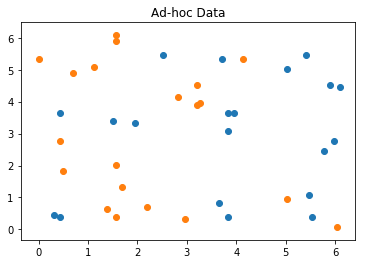

{'A': 0, 'B': 1}


In [2]:
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    gap=0.3, 
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

With the dataset ready we can setup the [VQC](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQC.html) algorithm to do a classification. We use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) data encoding circuit from the Qiskit circuit library, like we did with QSVM. But this is a variational algorithm so we need a variational form, i.e. parameterized circuit, whose parameters can be varied by an optimizer when computing VQC's cost function. For this we choose [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) from the Qiskit circuit library. As the qasm_simulator has shot noise we choose to use [SPSA](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.SPSA.html) which is designed to perform under noisy conditions.

Here the BasicAer `qasm_simulator` is used with 1024 shots.

In [3]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = SPSA(maxiter=40, c0=4.0, skip_calibration=True)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqc.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], vqc.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

Testing success ratio: 0.9

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


Now VQC, as well as QSVM, have `train`, `test` and `predict` methods. The `run` method, as used above, will call these in turn based on whatever data was supplied to the algorithm. But the methods called directly to say train a model and then do predict. Since the vqc instance has already been trained, lets predict another set of sample datapoints by directly calling `predict`.

In [4]:
more_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
more_datapoints, _ = split_dataset_to_data_and_labels(more_test_data)

predicted_probabilities, predicted_labels = vqc.predict(datapoints[0])

print('Prediction from more_datapoints set:')
print(f'  ground truth: {map_label_to_class_name(more_datapoints[1], vqc.label_to_class)}')
print(f'  prediction:   {map_label_to_class_name(predicted_labels, vqc.label_to_class)}')
print(f'  success rate: {100*np.count_nonzero(predicted_labels == more_datapoints[1])/len(predicted_labels)}%')

Prediction from more_datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


Finally I will note that the Qiskit classifier algorithms can `save_model` after training and also `load_model` that had been previously saved.

In [5]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright